In [11]:
#Read and uncomppresing files
import gzip
import json

#Basic data treatment
import pandas as pd
import numpy as np
import ast

#Regular expresions
import re

#Datetime functionalities
from datetime import datetime

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Sentimental Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')

#Lenguaje detection 
from langdetect import detect

#Similarity
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rrangel4\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rrangel4\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#READING (Decompress and read json)  ------- 'steam_games' database
steam_games = '../../NOT_TO_GITHUB/Datasources/steam_games.json.gz'

data_list = []
non_read = []

with gzip.open(steam_games,'rt',encoding='utf-8') as archivo:
    for number_line, line in enumerate(archivo,start=1):
        #print(line)
        try:
            data = json.loads(line)
            data_list.append(data)
            

        except json.JSONDecodeError as e:
            #print(f"Error al decodificar JSON en la línea {number_line}: {e}")
            try:
                data = ast.literal_eval(line) # Mas seguro. manejar expresiones literales simples, como números, cadenas, listas, diccionarios, tuplas y valores booleanos.
                if isinstance(data,dict):
                    data_list.append(data)
                else:
                    non_read.append(number_line)
            except json.JSONDecodeError as e:
                non_read.append(number_line)

steam_games_df = pd.DataFrame(data_list)
steam_games_df.tail(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"
120444,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,681550,NaN


In [ ]:
#READING (Decompress and read json) ------- 'user_reviews' database
data_list = []
non_read = []

with gzip.open('../../NOT_TO_GITHUB/Datasources/user_reviews.json.gz','rt',encoding='utf-8') as archivo:
    for number_line, line in enumerate(archivo,start=1):
        #print(line)
        try:
            data = json.loads(line)
            data_list.append(data)
        except json.JSONDecodeError as e:
            #print(f"Error al decodificar JSON en la línea {number_line}: {e}")
            try:
                data = ast.literal_eval(line)
                if isinstance(data,dict):
                    data_list.append(data)
                else:
                    non_read.append(number_line)
            except json.JSONDecodeError as e:
                non_read.append(number_line)

user_reviews_df = pd.DataFrame(data_list)
user_reviews_df.head(2)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."


In [ ]:
user_reviews_unnesting_df = pd.DataFrame()

for indice, row in user_reviews_df.iterrows():
    user_id = row['user_id']
    user_url = row['user_url']
    reviews = row['reviews']

    for diccionario in reviews:
        fila = {'user_id':user_id,'user_url':user_url,**diccionario}
        user_reviews_unnesting_df = pd.concat([user_reviews_unnesting_df, pd.DataFrame([fila])], ignore_index=True)

user_reviews_unnesting_df

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...,...,...,...,...
59300,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...
59301,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...
59302,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...
59303,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,,Posted July 20.,,730,No ratings yet,True,:D


In [ ]:
#READING (Decompress and read json)  ------- 'user_items' database 
data_list = []
non_read = []
conteo_1 = 0 # .json.loads()
conteo_2 = 0 # ast.literal_eval()
conteo_3 = 0 # it Couldn't be do.
conteo_total = conteo_total
with gzip.open('../../NOT_TO_GITHUB/Datasources/users_items.json.gz','rt',encoding='utf-8') as archivo:
    for number_line, line in enumerate(archivo,start=1):
        try:
            data = json.loads(line)
            data_list.append(data)
            conteo_1+=1
            
        except json.JSONDecodeError as e:
            try:
                data = ast.literal_eval(line) 
                if isinstance(data,dict):
                    data_list.append(data)
                    conteo_2+=1
                else:
                    non_read.append(number_line)
                    conteo_3+=1
            except json.JSONDecodeError as e:
                non_read.append(number_line)
                conteo_3+=1
        conteo_4 = conteo_1 + conteo_2 + conteo_3
        if (conteo_4) % 5000 == 0:
            print((conteo_4/conteo_total)*100)

user_items_df = pd.DataFrame(data_list)
user_items_df.head(2)

5.661872947571057
11.323745895142114
16.98561884271317
22.647491790284228
28.30936473785528
33.97123768542634
39.6331106329974
45.294983580568456
50.956856528139504
56.61872947571056
62.280602423281614
67.94247537085268
73.60434831842373
79.2662212659948
84.92809421356586
90.58996716113691
96.25184010870797


,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."


In [ ]:
#UNNESTING  ------- 'user_items' database 

#Take items column and convert each element of list in row
item_column = user_items_df['items'].explode()

# Filter elements that aren't diccionaries
item_column_filter = item_column[item_column.apply(lambda x: isinstance(x, dict))]

# turn this serie into dataframe
user_items_unnesting_df = pd.DataFrame(list(item_column_filter), index=item_column_filter.index)

# merge with original dataframe and reset the index.
user_items_unnesting_df = pd.merge(user_items_df,user_items_unnesting_df, how='left', left_index=True, right_index=True).reset_index()
user_items_unnesting_df.head(2)

,index,user_id,items_count,steam_id,user_url,items,item_id,item_name,playtime_forever,playtime_2weeks
0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...",10,Counter-Strike,6.0,0.0
1,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...",20,Team Fortress Classic,0.0,0.0


<span style="font-size: 24px; font-weight: bold;">Sentimental Analysis</span>  

In [ ]:
#Sentimental analysis of the Reviews column on the user_reviews dataset:
analyzer = SentimentIntensityAnalyzer()
#Add original Score from sentimental analysis (compound)
user_reviews_unnesting_df['sentimental_score'] = user_reviews_unnesting_df['review'].apply(lambda x: list((analyzer.polarity_scores(x)).values())[3])

user_reviews_unnesting_df['mood'] = user_reviews_unnesting_df['review'].apply(lambda x: 2 if (list((analyzer.polarity_scores(x)).values())[3]) >   0.1 else #Positive
                                                                                             ( 1 if (list((analyzer.polarity_scores(x)).values())[3]) >= -0.1 else #Neutral
                                                                                               0 ))                                                                #Negative


Text(0.5, 1.0, 'Mood')

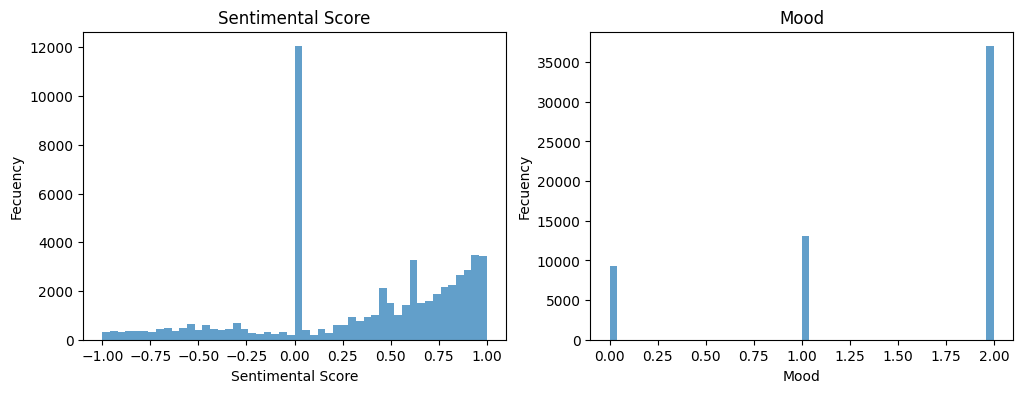

In [ ]:
# Analysis about sentimental score close to zero or equal to zero
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].hist(user_reviews_unnesting_df['sentimental_score'], bins=50, alpha=0.7) # Found out -0.25 and 0.25 tehre are many rows. Iteration 2 beter  zoom between -0.025 to 0.025
axs[0].set_xlabel('Sentimental Score')
axs[0].set_ylabel('Fecuency')
axs[0].set_title('Sentimental Score')


axs[1].hist(user_reviews_unnesting_df['mood'], bins=50, alpha=0.7)
axs[1].set_xlabel('Mood')
axs[1].set_ylabel('Fecuency')
axs[1].set_title('Mood')



<span style="font-size: 24px; font-weight: bold;">Analysis about idioms</span>  

In [12]:
#Identifying Idioms of the reviews

idioms = []

#Iterating on the user_reviews dataset
for row, i in enumerate(user_reviews_unnesting_df['review'],start=0):
    try:
        #Identifying the language used to write the review
        idioms.append(detect(i))
    except Exception as e:
        idioms.append('idiom non-detected')

# Adding the idiom column  to the user_reviews dataset
user_reviews_unnesting_df['idiom'] = idioms

[Text(0, 0, '77.1'),
 Text(0, 0, '3.7'),
 Text(0, 0, '2.2'),
 Text(0, 0, '1.9'),
 Text(0, 0, '1.7'),
 Text(0, 0, '1.3'),
 Text(0, 0, '1.2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '0.8')]

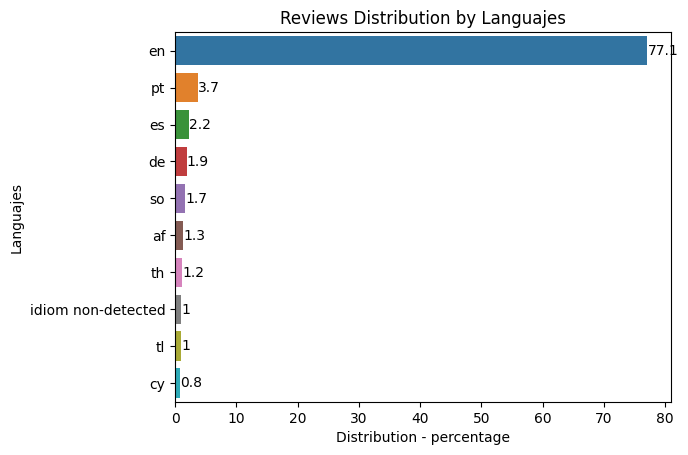

In [27]:
#Distribution reviews by idiom - TOTAL:
# count by idiom and % of it
distribution_languajes = user_reviews_unnesting_df['idiom'].value_counts().to_frame().reset_index()
distribution_languajes.rename(columns={"idiom": "count", "index": "idiom"}, inplace=True)
distribution_languajes['percentage'] = round((distribution_languajes['count']/distribution_languajes['count'].sum())*100,1)

# Acumulative:
distribution_languajes['Acum'] = round((distribution_languajes['count'].cumsum()/distribution_languajes['count'].sum())*100,1)

# 77% of reviews are in english.
grafic = sns.barplot(distribution_languajes.head(10), x='percentage', y='idiom')
grafic.set_xlabel('Distribution - percentage')
grafic.set_ylabel('Languajes')
grafic.set_title('Reviews Distribution by Languajes')

grafic.bar_label(grafic.containers[0])


<span style="font-size: 24px; font-weight: bold;">Analysis about idioms vs sentimental score</span>  

In [37]:
columns_to_drop = ['sentimental_2', 'sentimental']
user_reviews_unnesting_df.drop(columns=columns_to_drop, inplace=True)
user_reviews_unnesting_df.head(2)


,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,sentimental_score,mood,idiom
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted November 5, 2011.",NaN,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,0.8481,2,en
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,NaN,"Posted July 15, 2011.",NaN,22200,No ratings yet,True,It's unique and worth a playthrough.,0.2263,2,en


Text(0.5, 1.0, 'Mood  (english only)')

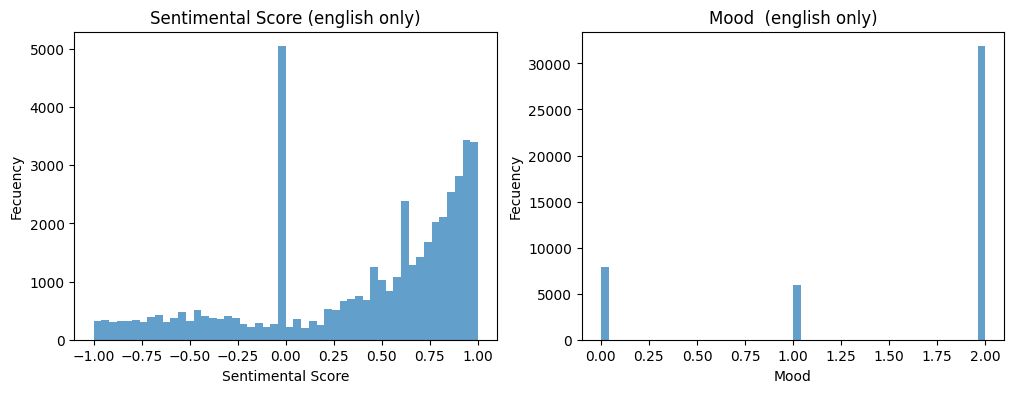

In [39]:
# Analysis about sentimental score close to zero or equal to zero
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].hist(user_reviews_unnesting_df['sentimental_score'][user_reviews_unnesting_df['idiom']=='en'], bins=50, alpha=0.7) # Found out -0.25 and 0.25 tehre are many rows. Iteration 2 beter  zoom between -0.025 to 0.025
axs[0].set_xlabel('Sentimental Score')
axs[0].set_ylabel('Fecuency')
axs[0].set_title('Sentimental Score (english only)')


axs[1].hist(user_reviews_unnesting_df['mood'][user_reviews_unnesting_df['idiom']=='en'], bins=50, alpha=0.7)
axs[1].set_xlabel('Mood')
axs[1].set_ylabel('Fecuency')
axs[1].set_title('Mood  (english only)')



Text(0.5, 1.0, 'Mood  (except english)')

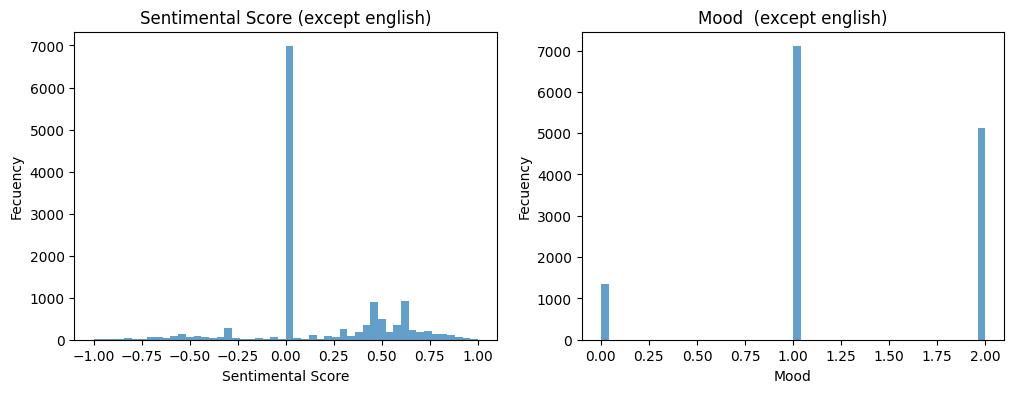

In [41]:
# Analysis about sentimental score close to zero or equal to zero
fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].hist(user_reviews_unnesting_df['sentimental_score'][user_reviews_unnesting_df['idiom']!='en'], bins=50, alpha=0.7) # Found out -0.25 and 0.25 tehre are many rows. Iteration 2 beter  zoom between -0.025 to 0.025
axs[0].set_xlabel('Sentimental Score')
axs[0].set_ylabel('Fecuency')
axs[0].set_title('Sentimental Score (except english)')


axs[1].hist(user_reviews_unnesting_df['mood'][user_reviews_unnesting_df['idiom']!='en'], bins=50, alpha=0.7)
axs[1].set_xlabel('Mood')
axs[1].set_ylabel('Fecuency')
axs[1].set_title('Mood  (except english)')



**Conclusions regarding idioms and sentimental score**


+ Most reviews (77%) are written in English.  
+ The general sentiment distribution has a positive trend.
+ The "English only" sentiment distribution has a positive trend.
+ But the "English excluded" distribution has a neutral trend.
+ So the non-English reviews introduce a neutral bias. This could be related to the potential of the SentimentIntensityAnalyzer algorithm to really determine the sentiment of non-English texts.




**Auxiliary analyses or analyses to be discarded**

In [ ]:
#Distribution reviews by Sentimental Score - TOTAL:
# count by idiom and percentage of it
distribution_senti_score = user_reviews_unnesting_df['sentimental_score'].value_counts().to_frame().reset_index()
distribution_senti_score.rename(columns={"sentimental_score": "count", "index": "sentimental_score"}, inplace=True)
distribution_senti_score['percentage'] = round((distribution_senti_score['count']/distribution_senti_score['count'].sum())*100,1)

# Acumulative:
distribution_senti_score['Acum'] = round((distribution_senti_score['count'].cumsum()/distribution_senti_score['count'].sum())*100,1)

# Chage of format (float to str)
distribution_senti_score['sentimental_score'] = distribution_senti_score['sentimental_score'].astype(str)

# 19% of reviews was rated with zero.
grafic = sns.barplot(distribution_senti_score.head(10), x='percentage', y='sentimental_score')
grafic.set_xlabel('Distribution - percentage')
grafic.set_ylabel('Sentimental Score')
grafic.set_title('Reviews Distribution by Sentimental Score (compound)')

grafic.bar_label(grafic.containers[0])

In [ ]:
#Distribution reviews by idiom - ONLY ZERO sentimental score:
# count by idiom and % of it
distribution_languajes_zero = user_reviews_unnesting_df[user_reviews_unnesting_df['sentimental_score']==0]['idiom'].value_counts().to_frame().reset_index()
distribution_languajes_zero.rename(columns={"idiom": "count", "index": "idiom"}, inplace=True)
distribution_languajes_zero['%'] = round((distribution_languajes_zero['count']/distribution_languajes_zero['count'].sum())*100,1)

# Acumulative:
distribution_languajes_zero['Acum'] = round((distribution_languajes_zero['count'].cumsum()/distribution_languajes_zero['count'].sum())*100,1)

# Almost 60% of reviews rated with ZERO are writteh another idiom than english
grafic = sns.barplot(distribution_languajes_zero.head(10), x='%', y='idiom')
grafic.set_xlabel('Distribution - %')
grafic.set_ylabel('Sentimental Score')
grafic.set_title('Reviews Distribution by ZERO Sentimental Score')

grafic.bar_label(grafic.containers[0])

In [ ]:
#Distribution reviews by idiom - Neutral mood:
# count by idiom and % of it
distribution_languajes_zero = user_reviews_unnesting_df[user_reviews_unnesting_df['mood']==1]['idiom'].value_counts().to_frame().reset_index()
distribution_languajes_zero.rename(columns={"idiom": "count", "index": "idiom"}, inplace=True)
distribution_languajes_zero['%'] = round((distribution_languajes_zero['count']/distribution_languajes_zero['count'].sum())*100,1)

# Acumulative:
distribution_languajes_zero['Acum'] = round((distribution_languajes_zero['count'].cumsum()/distribution_languajes_zero['count'].sum())*100,1)

# Almost 60% of reviews rated with ZERO are writteh another idiom than english
grafic = sns.barplot(distribution_languajes_zero.head(10), x='%', y='idiom')
grafic.set_xlabel('Distribution - %')
grafic.set_ylabel('Sentimental Score')
grafic.set_title('Reviews Distribution by Neutral Mood')

grafic.bar_label(grafic.containers[0])

In [ ]:
#Distribution reviews by idiom - Neutral mood:
# count by idiom and % of it
distribution_languajes_zero = user_reviews_unnesting_df[user_reviews_unnesting_df['mood']==1]['idiom'].value_counts().to_frame().reset_index()
distribution_languajes_zero.rename(columns={"idiom": "count", "index": "idiom"}, inplace=True)
distribution_languajes_zero['%'] = round((distribution_languajes_zero['count']/distribution_languajes_zero['count'].sum())*100,1)

# Acumulative:
distribution_languajes_zero['Acum'] = round((distribution_languajes_zero['count'].cumsum()/distribution_languajes_zero['count'].sum())*100,1)

# Almost 60% of reviews rated with ZERO are writteh another idiom than english
grafic = sns.barplot(distribution_languajes_zero.head(10), x='%', y='idiom')
grafic.set_xlabel('Distribution - %')
grafic.set_ylabel('Sentimental Score')
grafic.set_title('Reviews Distribution by Neutral Mood')

grafic.bar_label(grafic.containers[0])

In [ ]:
#Distribution reviews by Sentimental Score - TOTAL:
# count by idiom and percentage of it
distribution_senti_score = user_reviews_unnesting_df['sentimental_score'][user_reviews_unnesting_df['idiom']=='en'].value_counts().to_frame().reset_index()
distribution_senti_score.rename(columns={"sentimental_score": "count", "index": "sentimental_score"}, inplace=True)
distribution_senti_score['percentage'] = round((distribution_senti_score['count']/distribution_senti_score['count'].sum())*100,1)

# Acumulative:
distribution_senti_score['Acum'] = round((distribution_senti_score['count'].cumsum()/distribution_senti_score['count'].sum())*100,1)

# Chage of format (float to str)
distribution_senti_score['sentimental_score'] = distribution_senti_score['sentimental_score'].astype(str)

# 19% of reviews was rated with zero.
grafic = sns.barplot(distribution_senti_score.head(10), x='percentage', y='sentimental_score')
grafic.set_xlabel('Distribution - percentage')
grafic.set_ylabel('Sentimental Score')
grafic.set_title('Reviews Distribution by Sentimental Score (compound)')

grafic.bar_label(grafic.containers[0])

In [ ]:
#Distribution reviews by Sentimental Score - TOTAL:
# count by idiom and percentage of it
distribution_senti_score = user_reviews_unnesting_df['sentimental_score'][user_reviews_unnesting_df['idiom']=='en'].value_counts().to_frame().reset_index()
distribution_senti_score.rename(columns={"sentimental_score": "count", "index": "sentimental_score"}, inplace=True)
distribution_senti_score['percentage'] = round((distribution_senti_score['count']/distribution_senti_score['count'].sum())*100,1)

# Acumulative:
distribution_senti_score['Acum'] = round((distribution_senti_score['count'].cumsum()/distribution_senti_score['count'].sum())*100,1)

# Chage of format (float to str)
distribution_senti_score['sentimental_score'] = distribution_senti_score['sentimental_score'].astype(str)

# 19% of reviews was rated with zero.
grafic = sns.barplot(distribution_senti_score.head(10), x='percentage', y='sentimental_score')
grafic.set_xlabel('Distribution - percentage')
grafic.set_ylabel('Sentimental Score')
grafic.set_title('Reviews Distribution by Sentimental Score (compound)')

grafic.bar_label(grafic.containers[0])